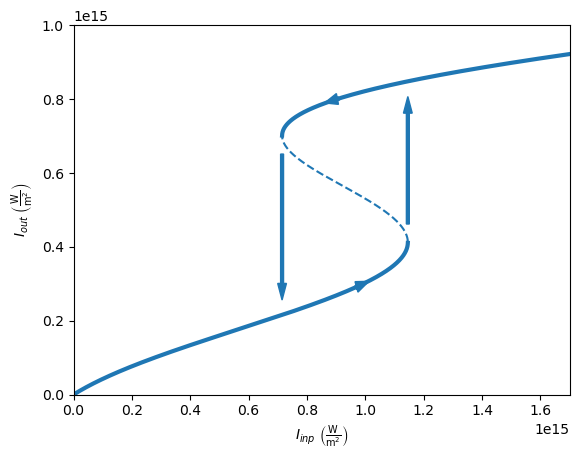

In [ ]:
import meep as mp
from meep.materials import GaAs
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

c = 2.998e8  # speed of light
a = 1e-6  # charasteristic length scale (m)

L_SI = 15e-6  # length of chi3 cavity (m)
lambda_SI = 1550e-9  # laser wavelength (m)
omega_SI = 2*np.pi*c/lambda_SI
lambda_ = lambda_SI/a  # wavelength in Meep units

n0 = np.sqrt(GaAs.epsilon(1/lambda_)[0,0])  # linear refractive index at laser frequency
n2_SI = 2e-17  # nonlinear refractive index in m^2/W. Hales et.al [2]
# source: Hales et.al., Third-Order Nonlinear Optical Coefficients of Si and GaAs in the Near-Infrared Spectral Region

# reflectivity and transmittivity of GaAs-air interface from Fresnel equation
R = ((1-n0)/(1+n0))**2
T = 1-R

# we have found alpha by fitting it to our simulation results (see below)
alpha = 1.93

# calculate input intensity as a function of output intensity
I_out_SI = np.linspace(0, 1e15, 1000)
phi = omega_SI/c * (n0 + alpha*n2_SI*I_out_SI/T)*L_SI
I_inp_SI = (1 + 4*R/T**2*np.sin(phi)**2)*I_out_SI   

# plot output intensity as a function of input intensity
fig, ax = plt.subplots()
color = 'tab:blue'
ax.plot(I_inp_SI, I_out_SI, '--', color=color)

# find the discontinuous jumps of output intensity (which correspond
# to local maxima and minima of input intensity) and plot lower and
# upper arms of the curve with a thicker line
discon_idx_incr = argrelextrema(I_inp_SI, np.greater)[0][0]
discon_idx_decr = argrelextrema(I_inp_SI, np.less)[0][0]
ax.plot(I_inp_SI[:discon_idx_incr], I_out_SI[:discon_idx_incr], linewidth=3, color=color)
ax.plot(I_inp_SI[discon_idx_decr:], I_out_SI[discon_idx_decr:], linewidth=3, color=color)

# add arrows to help visualize the intensity path
arrow_width = 1e13
ax.arrow(I_inp_SI[discon_idx_incr], I_out_SI[discon_idx_incr]+5e13,0, 3e14,
         width = arrow_width, color=color)
ax.arrow(I_inp_SI[discon_idx_decr], I_out_SI[discon_idx_decr]-5e13,0, -3.5e14,
         width = arrow_width, color=color)
idx1 = 290
ax.arrow(I_inp_SI[idx1], I_out_SI[idx1],
         I_inp_SI[idx1+1]-I_inp_SI[idx1], I_out_SI[idx1+1]-I_out_SI[idx1],
         width=arrow_width, color=color)
idx2 = 800
ax.arrow(I_inp_SI[idx2], I_out_SI[idx2],
         I_inp_SI[idx2]-I_inp_SI[idx2+1], I_out_SI[idx2]-I_out_SI[idx2+1],
         width=arrow_width, color=color)

ax.set_xlim([0, 1.7e15])
ax.set_ylim([0, 1e15])
ax.set_xlabel(r"$I_{inp} \ \left( \frac{\text{W}}{\text{m}^2} \right)$")
ax.set_ylabel(r"$I_{out} \ \left( \frac{\text{W}}{\text{m}^2} \right)$")

fig.savefig('optical_bistability_theory.png', dpi=300, bbox_inches='tight')

In [ ]:
# define cell
pml_size = 1
pml_layers = [mp.PML(pml_size)]
L = L_SI/a  # length of chi3 cavity in Meep units
cavity_gap = 2  # source-cavity and cavity-ouput monitor gap
cell_len = L + 2*pml_size + 2*cavity_gap
cell = mp.Vector3(0, 0, cell_len)

# define cavity with third order nonlinearity
cavity_material = GaAs
n2 = 0.01  # nonlinear refractive index in Meep units
chi3 = 4/3 * n2*n0**2  # notice lack of epsilon_0 and c due to Meep units
cavity_material.E_chi3_diag = mp.Vector3(chi3, chi3, chi3)  # add third order nonlinearity
geometry = [mp.Block(size=mp.Vector3(0,0,L),
                      center=mp.Vector3(0,0,0),
                      material=cavity_material)]

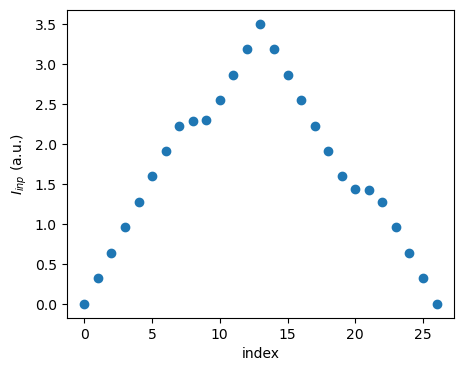

In [ ]:
I_inp_increasing = np.linspace(0, 3.5, 12)

# find the discontinuous jumps of output intensity predicted
# by the theory. Discontinuities correspond to local maxima
# and minima of input intensity.
discon_idx_incr = argrelextrema(I_inp_SI, np.greater)[0][0]
discon_idx_decr = argrelextrema(I_inp_SI, np.less)[0][0]

# convert input intensities at discontinuities from SI units
# to Meep units. The conversion is based onthe fact that n_2*I
# is dimensionless, so it's value is same in Meep and SI units.
I_inp_discon_incr = I_inp_SI[discon_idx_incr]*n2_SI/n2
I_inp_discon_decr = I_inp_SI[discon_idx_decr]*n2_SI/n2

# determine input intensities just before and after the discontinuity
discon_gap = I_inp_increasing.max()/200
points_incr = [I_inp_discon_incr - discon_gap/2, I_inp_discon_incr + discon_gap/2]
points_decr = [I_inp_discon_decr + discon_gap/2, I_inp_discon_decr - discon_gap/2]

# put increasing and decreasing intensities to a single vector
I_inp_incr = np.sort(np.hstack((I_inp_increasing, points_incr)))
I_inp_decr = np.sort(np.hstack((I_inp_increasing, points_decr)))[::-1]
I_inp = np.hstack((I_inp_incr, I_inp_decr[1:]))

# plot the input intensities
fig, ax = plt.subplots()
ax.plot(I_inp, "o")
ax.set_xlabel('index')
ax.set_ylabel(r"$I_{inp} \ \left( \text{a.u.} \right)$")
fig.set_size_inches(5,4)

fig.savefig('input_intensities.png', dpi=300, bbox_inches='tight')

In [ ]:
class simControl:
    """Class for creating an adaptive simulation, where it is automatically
    detected when output intensity has stabilized, after which output
    intensity is measured and next input intensity transition is started.
    """

    def __init__(self, I_inp, source_freq):
        """Initialize object.
        
        :param I_inp: np.ndarray, vector of input intensities in Meep units
        :param source_freq: float, source frequency in Meep units
        """
        
        # convert intensity to electric field (note lack of c and epsilon_0
        # due to Meep units)
        E_inp = np.sqrt(2*I_inp)
        # convert electric field to source current amplitude
        # E = Z*current_amplitude/2, where Z = np.sqrt(1/eps) = 1
        self.input_amps = 2*E_inp

        # current source current amplitude index
        self.amp_idx = 0

        # initialize output intensities
        self.I_out = np.zeros(self.input_amps.shape)

        # current time and time index
        self.t = 0
        self.ti = 0

        # time duration for gradual input intensity transition
        self.transition_duration = 500
        # start time of latest transition
        self.transition_start_t = 0
        self.in_transition = False
        # determines the range of x values of the hyperbolic tangent
        # shaped transition
        self.k = 2.5

        self.freq = source_freq

        # initialize list for storing source amplitude envelope
        self.source_envelope_all = []
        # initialize list for storing output Poynting vector values
        self.S_all = []
        # determines how frequenntly output Poynting vector is measured
        self.S_measurement_dt = 0.03/self.freq
        # averaging window length for obtaining output intensity by time
        # averaging Poynting vector
        self.S_averaging_window_len = 80/self.freq

        # determines how frequently output intensity stability is measured
        self.stability_measurement_period = 100
        # time window length within which the stability is measured
        self.stability_measurement_window = 500
        # tolerance for output intensity stability
        self.stability_tol = 1e-3*I_inp.max()
        # maximum time to wait before next transition if output intensity
        # doesn't stabilize naturally
        self.max_stabilization_t = 10000
    
    def source_envelope(self, t):
        """Envelope function of current source. Uses hyperbolic tangent function
        for creating a smooth transition between two input intensities.
        
        :param t: float, time in Meep units
        :return: float, envelope value"""

        if self.amp_idx >= self.input_amps.size-1:
            return 0
        
        y = self.input_amps[self.amp_idx]

        if self.in_transition:
            t_trans = t - self.transition_start_t

            if t_trans >= self.transition_duration:
                # if transition is complete, update object internal state
                print("transition complete")
                self.in_transition = False
                y += self.input_amps[self.amp_idx+1] - self.input_amps[self.amp_idx]
                self.amp_idx += 1

            else:
                # implement hyperbolic tangent transition function
                amp_step = self.input_amps[self.amp_idx+1] - self.input_amps[self.amp_idx]
                y_step = (amp_step*(np.tanh(2*self.k/self.transition_duration*t_trans - self.k)
                                    / np.tanh(self.k)+1)/2)
                y += y_step
        
        return y
    
    def source_func(self, t):
        """Current source function.
        
        :param t: float, time in Meep units
        :return: complex, source value
        """
        
        # update time and time index
        self.t = t
        self.ti += 1

        # calculate and store envelope value
        y = self.source_envelope(t)
        if self.ti%10000 == 0:
            self.source_envelope_all.append(y)

        # add phase
        return y*np.exp(1j*2*np.pi*self.freq*t)
    
    def measure_S_out(self, sim):
        """Measures output Poynting vector z component
        
        :param sim: mp.simulation.Simulation, simulation object
        """

        # obtain Ex and Hy after the nonlinear cavity
        Ex = sim.get_field_point(c=mp.Ex, pt=mp.Vector3(0,0,cell_len/2-pml_size)).real
        Hy = sim.get_field_point(c=mp.Hy, pt=mp.Vector3(0,0,cell_len/2-pml_size)).real

        # calculate and store Sz
        Sz = Ex*Hy
        self.S_all.append(Sz)

        # Contrary to the information in the official documentation, it appears that
        # c=mp.Sz (derived component) isn't supported for get_field_point. We had to
        # calculate S manually.
    
    def output_stability_check(self, sim):
        """Tests if output intensity has stabilized. First obtains output intensity by
        time averaging Poynting vector values, and then tests if maximum variation of
        output intensity is smaller than tolerance.
        
        :param sim: mp.simulation.Simulation, simulation object
        """

        if self.t == 0 or self.in_transition:
            return

        # obtain latest output intensities by time averaging Poynting vector values
        dt = self.t / len(self.S_all)
        N = int(self.stability_measurement_window / dt)
        S = np.array(self.S_all[-N:])
        N_window = int(self.S_averaging_window_len/dt)
        averaging_window = np.ones(N_window)/N_window
        I = np.convolve(S, averaging_window, mode='valid')

        # output intensity range
        range_ = I.max()-I.min()

        print(f"progress: {self.amp_idx}/{self.input_amps.size-1}")
        print("testing stability")

        # test if output intensity has stabilized
        if (range_ < self.stability_tol or
            self.t-(self.transition_start_t+self.transition_duration)>self.max_stabilization_t):

            if range_ < self.stability_tol:
                print("  stability reached, starting transition")
            else:
                print("  max stabilization time passed")
                print("  starting transition despite no stabilization")
            
            # if output intensity is stabilized, update internal state of object and store
            # output intensity
            self.in_transition = True
            self.transition_start_t = self.t
            self.I_out[self.amp_idx] = I.mean()

        else:
            print(f"  not stabilized, range={range_:.5f} > tol={self.stability_tol:.5f}")

    def simulation_stop_check(self, sim):
        """Tests if simulation is done, i.e. all input intensities have been
        used.
        
        :param sim: mp.simulation.Simulation, simulation object
        """

        return self.amp_idx >= self.input_amps.size-1
    

# define object for controlling simulation
sim_control = simControl(I_inp=I_inp, source_freq=1/lambda_)

# define source
source_func = lambda sim: sim_control.source_func(sim)
sources = [mp.Source(mp.CustomSource(source_func, end_time=mp.inf),
                     component=mp.Ex,
                     center=mp.Vector3(0,0, -cell_len/2+pml_size))]

# define simulation object
resolution = 512
sim = mp.Simulation(
    cell_size=cell,
    sources=sources,
    boundary_layers=pml_layers,
    geometry=geometry,
    resolution=resolution,
    dimensions=1,
)

In [5]:
measure_func = lambda sim: sim_control.measure_S_out(sim)
stability_func = lambda sim: sim_control.output_stability_check(sim)
stop_func = lambda sim: sim_control.simulation_stop_check(sim)

# custom functions can be used during the simulation with at_every function
sim.run(mp.at_every(sim_control.S_measurement_dt, measure_func),
        mp.at_every(sim_control.stability_measurement_period, stability_func),
        until=stop_func)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000576973 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 21 with resolution 512
     block, center = (0,0,0)
          size (0,0,15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.37251,5.37251,5.37251)
time for set_epsilon = 0.00430989 s
lorentzian susceptibility: frequency=0.0270881, gamma=0
lorentzian susceptibility: frequency=1.14332, gamma=0
lorentzian susceptibility: frequency=2.25667, gamma=0
-----------
on time step 69187 (time=67.5654), 5.7815e-05 s/step
progress: 0/26
testing stability
  stability reached, starting transition
on time step 132844 (time=129.73), 6.28369e-05 s/step
on time step 194882 (time=190.314), 6.44768e-05 s/step
on time step 256829 (time=250.81), 6.45717e-05 s/step
on time step 318263 (time=310.804), 6.51108e-05 s/step
on time step 379411 (time=370.519), 6.54157e-05 s/step
on time step 440754 (time=430.424), 6.52075e-05 s/step
o

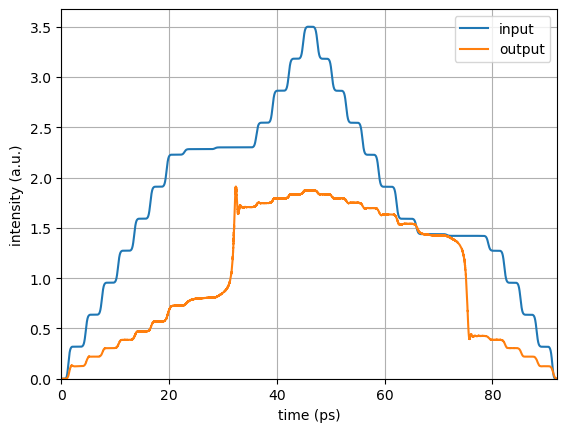

In [89]:
# time vectors corresponding to Poynting values and source envelope
t_S = np.linspace(0,sim_control.t, len(sim_control.S_all))
t_source = np.linspace(0,sim_control.t, len(sim_control.source_envelope_all))

# obtain output intensities by time averaging Poynting vector values
dt = sim_control.t / len(sim_control.S_all)
N_window = int(sim_control.S_averaging_window_len/dt)
averaging_window = np.ones(N_window)/N_window
I_out_envelope = np.convolve(sim_control.S_all, averaging_window, mode='same')

# convert source current amplitudes to input intensities. Uses equations
# I=1/2*E^2 (note lack of c and epsilon_0 due to Meep units and n=1) and
# E = Z*current_amplitude/2, where Z = np.sqrt(1/eps) = 1
I_inp_envelope = 1/8 * np.array(sim_control.source_envelope_all)**2

# time conversion factor from Meep units to seconds
time_conversion = a/c*1e12

# plot input and output intensities as a function of time
fig, ax = plt.subplots()
ax.plot(t_source*time_conversion, I_inp_envelope, label='input')
ax.plot(t_S*time_conversion, I_out_envelope, label='output')
ax.set_xlim([0, t_S[-1]*time_conversion])
ax.set_ylim([0, 1.05*I_inp.max()])
ax.set_xlabel('time (ps)')
ax.set_ylabel('intensity (a.u.)')
ax.grid()
ax.legend()

fig.savefig('intensity_time.png', dpi=300, bbox_inches='tight')

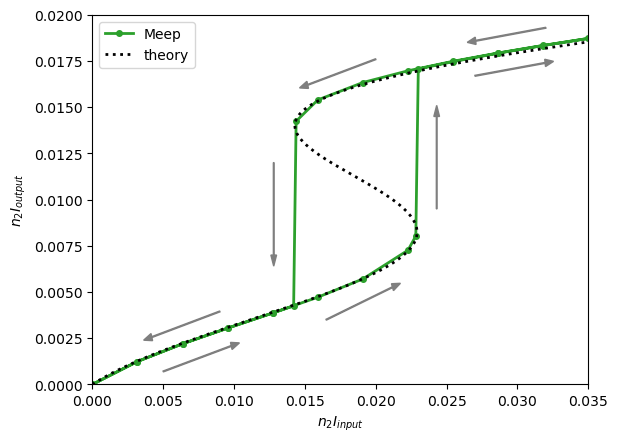

In [ ]:
# plot Meep result and theory
fig, ax = plt.subplots()
ax.plot(n2*I_inp, n2*sim_control.I_out, 'o-', label="Meep", linewidth=2,
        markersize=4, color='tab:green')
ax.plot(n2_SI*I_inp_SI, n2_SI*I_out_SI, 'k:', label="theory", linewidth=2)
ax.set_xlim([0, np.max(n2*I_inp)])
ax.set_ylim([0,0.02])
ax.set_xlabel(r"$n_2I_{input}$")
ax.set_ylabel(r"$n_2I_{output}$")
ax.legend()

# add arrows to help visualize intensity path
arrow_coords = [[0.005, 0.0007],
                [0.0165, 0.0035],
                [0.0243, 0.0095],
                [0.027, 0.0167],
                [0.032, 0.0193],
                [0.02, 0.0176],
                [0.0128, 0.012],
                [0.009, 0.00395]]
thetas = [0.28, 0.36, np.pi/2, 0.14, -3.00, -2.86, -np.pi/2, -2.86]
arrow_len = 0.005
for coord, theta in zip(arrow_coords, thetas):
    x, y = coord
    delta_x = arrow_len*np.cos(theta)
    delta_y = arrow_len*np.sin(theta)
    ax.arrow(x, y, delta_x, delta_y, width=0.00005,
             head_width=0.0004, color='tab:gray')

fig.savefig('hysteresis_loop.png', dpi=300, bbox_inches='tight')